In [1]:
import numpy as np
from classy import Class
from Francisco import trapezoid, right_rectangle, factors, xy_values
import scipy.interpolate as sp
import matplotlib.pyplot as plt

In [2]:
M_sol = 1.989e30 # solar mass in kg
Mpc = 3.086e22 # Mpc in m
c=np.logspace(-11.3,-5, 40)
kvec = np.logspace(-4,np.log10(100),100)
measured_omegacdm=.1188
Sig_8 = 0.811
A_s = 2.1e-9

In [3]:
commonsettings = {
          'N_ncdm':1,
          'use_ncdm_psd_files': 1,
          'm_ncdm': 7100,
          'T_ncdm':0.7,
          'output':'mPk',
          'P_k_max_1/Mpc':100.0,
          ## The next line should be uncommented fgor higher precision (but significantly slower running)
          'ncdm_fluid_approximation':3,
          ## You may uncomment this line to get more info on the ncdm sector from Class:
          'background_verbose':1,
          'Maximum q':100
         } 

In [4]:
dat = np.load('1x0.00049x3e-09-data.npz')
omega_h_h = dat['omega_s']
a,b,c,d,e = xy_values('1x0.00049x3e-09-data.npz', 20)
np.savetxt("Spec", np.column_stack((a,b)))
spec_file  = 'Spec'

['eps', 'f', 'eps_full', 'f_full', 'omega_s', 'a', 'T', 'Lep']


In [5]:
def ideal_sigma8 (spec_file, omega_h_h):
    
    NH = Class()
        #use method .set() to 
    NH.set(commonsettings)
    othersettings = { 'ncdm_psd_filenames': spec_file,
                      'omega_cdm': measured_omegacdm - omega_h_h, 
                      'omega_ncdm': omega_h_h, 
                      'A_s': 2.1e-9,
                    }

    #use method .compute() to get data for my specific 'Spec-' file
    NH.set(othersettings)
    NH.compute()

    Sigma8_value = NH.sigma8()
    print("",Sigma8_value,"")
    
    ideal_value = ((Sig_8)/(Sigma8_value))**2*(A_s)
    
    NH.struct_cleanup()
    
    return ideal_value

In [6]:
def make_Pk(spec_file,omega_h_h):
    
    othersettings = { 'ncdm_psd_filenames': spec_file,
                      'omega_cdm': measured_omegacdm - omega_h_h, 
                      'omega_ncdm': omega_h_h, 
                      'A_s': ideal_sigma8(spec_file, omega_h_h),
                    }
    
    for key, value in othersettings.items():
        print(key, ' : ', value)
    for key, value in commonsettings.items():
        print(key, ' : ', value)
    
    # array of k values in 1/Mpc


    NH = Class()
    NH.set(commonsettings)
    NH.set(othersettings)
    NH.compute()
    
    new_sig8 = NH.sigma8()
    pkNH = [] 
    
        #MPk- Matter Power Spectrum
    for k in kvec:
        pkNH.append(NH.pk(k,0.))
    h = NH.h()
    NH.struct_cleanup()
    

    np.save(spec_file+ '-Pknew',np.array(pkNH))
    np.save(spec_file+'-knew',kvec/h)
    
    return new_sig8

**With k = 20**

In [7]:
%%time
make_Pk(spec_file, omega_h_h)

 0.7866071721193716 
ncdm_psd_filenames  :  Spec
omega_cdm  :  0.05941682610033301
omega_ncdm  :  0.05938317389966699
A_s  :  2.2322621700046643e-09
N_ncdm  :  1
use_ncdm_psd_files  :  1
m_ncdm  :  7100
T_ncdm  :  0.7
output  :  mPk
P_k_max_1/Mpc  :  100.0
ncdm_fluid_approximation  :  3
background_verbose  :  1
Maximum q  :  100
CPU times: user 2min 19s, sys: 1.62 s, total: 2min 20s
Wall time: 2min 20s


0.8109999999999996

**With k = 4**

In [8]:
a,b,c,d,e = xy_values('1x0.00049x3e-09-data.npz', 4)

In [9]:
np.savetxt("Spec", np.column_stack((a,b)))
spec_file  = 'Spec'

In [10]:
%%time
make_Pk(spec_file, omega_h_h)

 0.7537938931744148 
ncdm_psd_filenames  :  Spec
omega_cdm  :  0.05941682610033301
omega_ncdm  :  0.05938317389966699
A_s  :  2.430836639371758e-09
N_ncdm  :  1
use_ncdm_psd_files  :  1
m_ncdm  :  7100
T_ncdm  :  0.7
output  :  mPk
P_k_max_1/Mpc  :  100.0
ncdm_fluid_approximation  :  3
background_verbose  :  1
Maximum q  :  100
CPU times: user 4min 42s, sys: 4.38 s, total: 4min 46s
Wall time: 4min 46s


0.8109999999999995

In [12]:
def trap(f,x):
    integral = 0
    for i in range(1,len(f)):
        integral += 0.5 * (f[i] + f[i-1]) * (x[i] - x[i-1])
    return integral

def R(M):
    c = 2.5
    G = 6.67e-11 # m^3 / kg / s^2
    H100 = 100 * (1000/Mpc) # km/s/Mpc -> 1/s
    omegah2 = 0.1188

    rhobar = omegah2 * 3 * H100**2 / (8 * np.pi * G) / M_sol * Mpc**3 # kg / m^3 -> M_sol / Mpc^3
    return (3 * M / (4 * np.pi * rhobar * c**3))**(1/3) # Mpc

def W(k,R):
        if np.isscalar(k):
            if k * R > 1:
                return 0
            else:
                return 1
        else:
            result = np.zeros(len(k))
            for i in range(len(k)):
                if k[i] * R < 1 and k[i+1] * R > 1:
                    result[i] = (1 - k[i] * R)/(k[i+1]*R - k[i]*R)
                elif k[i] * R < 1:
                    result[i] = 1
            return result
        
def S(M):
        Rv = R(M)
        
        integrand = k_vals**2 * Pk_vals * W(k_vals, Rv)**2 / (2 * ( np.pi**2))
        return trap(integrand,k_vals)


def dNdlnM(M):
    Rv = R(M)
    return 1 / 44.5 / (6 * np.pi**2) * (M0 / M) / Rv**3 / np.sqrt(2 * np.pi * ( S(M) - S(M0))) * P_spline(1/Rv)
    


    
file_name = '1x0.00049x3e-09-data.npz'  ## trial run





def Bella_2(file_name, k): ##.npz as first input and step size as the second
    
    a,b,c,d,e = xy_values(file_name, k)
    
    dat = np.load(file_name)

    omega_h_h = dat['omega_s']
    a,b,c,d,e = xy_values(file_name, k)
    np.savetxt("Spec", np.column_stack((a,b)))
    spec_file  = 'Spec'
    
    make_Pk(spec_file, omega_h_h)
    
    global k_vals
    k_vals = np.load('Spec-knew.npy')
    global Pk_vals
    Pk_vals = np.load('Spec-Pknew.npy')
    

    global M0
    M0 = 3.2e12 # M_sol / h
    global P_spline
    P_spline  = sp.CubicSpline(k_vals,Pk_vals)


    global ln_vals
    lnM_vals = np.linspace(np.log(1e8),np.log(M0))
    
    sv = np.zeros(len(lnM_vals)-1)
    for i in range(len(sv)):
        sv[i] = S(np.exp(lnM_vals[i]))- S(np.exp(lnM_vals[-1]))
    
    integrand = np.zeros(len(lnM_vals)-1)

    for i in range(len(integrand)):
        integrand[i] = dNdlnM(np.exp(lnM_vals[i]))
        
    integral = trap(integrand,lnM_vals[:-1])
                
    return integral, integrand, sv, lnM_vals

a,b,c,d = Bella_2(file_name, 4)

 0.7537938931744148 
ncdm_psd_filenames  :  Spec
omega_cdm  :  0.05941682610033301
omega_ncdm  :  0.05938317389966699
A_s  :  2.430836639371758e-09
N_ncdm  :  1
use_ncdm_psd_files  :  1
m_ncdm  :  7100
T_ncdm  :  0.7
output  :  mPk
P_k_max_1/Mpc  :  100.0
ncdm_fluid_approximation  :  3
background_verbose  :  1
Maximum q  :  100


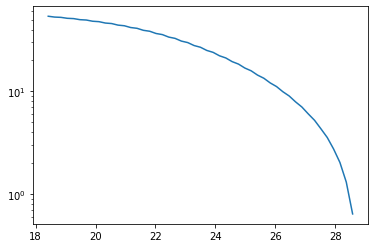

[53.92996336 52.93271637 52.59250624 51.49718928 51.14504895 49.93290973
 49.54279859 48.21120116 47.75354264 46.30369852 45.76630693 44.18927906
 43.56212207 41.85802135 41.13609506 39.32335933 38.50944428 36.61489804
 35.7179787  33.77780429 32.81303552 30.86704663 29.85236133 27.93558294
 26.88961488 25.03351106 23.97378641 22.2012598  21.14283863 19.46996851
 18.42569839 16.86305672 15.84280046 14.3946072  13.40631979 12.07422462
 11.12385304  9.9060308   8.99785461  7.89059166  7.02799268  6.02679859
  5.21180123  4.31070796  3.54485911  2.73802     2.02210748  1.30317291
  0.63742026]
[1.15946277e+02 9.78191634e+01 8.23522990e+01 6.99878122e+01
 5.92394828e+01 5.06009469e+01 4.30409398e+01 3.70272595e+01
 3.16834541e+01 2.74090625e+01 2.35150382e+01 2.03840984e+01
 1.74978032e+01 1.51765470e+01 1.29815196e+01 1.12037557e+01
 9.51956843e+00 8.16750092e+00 6.88863253e+00 5.86755059e+00
 4.90594439e+00 4.14491704e+00 3.43894230e+00 2.88669427e+00
 2.37905369e+00 1.98469219e+00 1.626

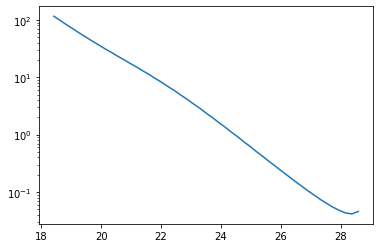

151.8334763426975


In [23]:
plt.figure()
plt.semilogy(d[:-1],c)
plt.show()
print(c)


for i in range(len(b)):
    b[i] = dNdlnM(np.exp(d[i]))
    
    
print(b)


print(a)
plt.figure()
plt.semilogy(d[:-1],b)
plt.show()    



print(a)    